## Compressing a VGG-16 trained on CIFAR-10

#### To replicate results with pretrained models please download the following models

1. vgg16_cifar10.pth
2. vgg16_cifar10_small_cup_t_point_9.pth
3. vgg16_cifar10_cupSS_K_point2.pth

In [5]:
import sys; sys.argv=['']; del sys
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
%matplotlib inline
plt.tight_layout()

import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from tensorboardX import SummaryWriter

import numpy as np
import random
import os
import time
import copy

os.environ["CUDA_VISIBLE_DEVICES"] = '4'

from src.utils import plot_tsne,fancy_dendrogram,save_obj,load_obj
from src.model import VGG,load_model
from src.prune_model import prune_model
from src.cluster_model import cluster_model
from src.train_test import train,test,adjust_learning_rate_nips,adjust_learning_rate_iccv

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<Figure size 432x288 with 0 Axes>

### Train baseline VGG-16 model

In [6]:
parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                    help='input batch size for training (default: 128)')
parser.add_argument('-j', '--workers', default=4, type=int, metavar='N',
                    help='number of data loading workers (default: 4)')
parser.add_argument('--epochs', default=160, type=int, metavar='N',
                    help='number of total epochs to run')
parser.add_argument('--lr', '--learning-rate', default=0.1, type=float,
                    metavar='LR', help='initial learning rate')
parser.add_argument('--momentum', default=0.9, type=float, metavar='M',
                    help='momentum')
parser.add_argument('--weight-decay', '--wd', default=1e-4, type=float,
                    metavar='W', help='weight decay (default: 1e-4)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=12346, metavar='S',
                    help='random seed (default: 12346)')
parser.add_argument('--num_output', type=int, default=10, metavar='S',
                    help='number of classes(default: 10)')
parser.add_argument('--log-interval', type=int, default=100, metavar='N',
                    help='how many batches to wait before logging training status')
parser.add_argument('--checkpoint_path', type=str, default='./checkpoints/vgg16_cifar10.pth', metavar='S',
                    help='path to store model training checkpoints')
parser.add_argument('--gpu', type=int, default=[5], nargs='+', help='used gpu')

args = parser.parse_args()


#set device to CPU or GPU
args = parser.parse_args()

use_cuda = not args.no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

writer = SummaryWriter('logs/vgg_16_cifar10/base_iccv_param/')

#set all seeds for reproducability
def set_random_seed(seed):    
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(args.seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True

set_random_seed(args.seed)


kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

train_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10(root='data/', train=True, transform=transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, 4),
            transforms.ToTensor(),
            normalize,
        ]), download=True),
        batch_size=args.batch_size, shuffle=True,
        num_workers=args.workers, pin_memory=True)

val_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10(root='data/', train=False, transform=transforms.Compose([
            transforms.ToTensor(),
            normalize,
        ])),
        batch_size=args.batch_size, shuffle=False,
        num_workers=args.workers, pin_memory=True)

vgg16_bn = VGG('VGG16',num_output=args.num_output)
vgg16_bn = vgg16_bn.to(device)
        
optimizer = optim.SGD(vgg16_bn.parameters(),lr=args.lr,momentum=args.momentum,weight_decay=args.weight_decay,nesterov=False)



Files already downloaded and verified


In [7]:
test_loss = 0
best_val_acc = 0

if not os.path.isfile(args.checkpoint_path):
    for epoch in range(1, args.epochs + 1):
        start = time.time()
        args.lr = adjust_learning_rate_iccv(args,optimizer,epoch)
        train_loss,train_acc = train(args,vgg16_bn,device,train_loader,optimizer,epoch)
        val_loss,val_acc = test(args,vgg16_bn,device,val_loader)

        writer.add_scalars('base_model/loss',{'train_loss': train_loss,
                                        'val_loss' : val_loss}, epoch)
        writer.add_scalars('base_model/accuracy',{'train_acc': train_acc,
                                            'val_acc' : val_acc}, epoch)    

        print('Time taken for epoch : {}\n'.format(time.time()-start))

        if val_acc > best_val_acc: 
            best_val_acc = val_acc

            torch.save({
                        'epoch': epoch,
                        'model_state_dict': vgg16_bn.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': val_loss,
                        }, args.checkpoint_path, pickle_protocol=4)
else:
    vgg16_bn,optimizer = load_model('vgg16_bn','sgd',args)
    orig_loss, orig_acc = test(args, vgg16_bn, device, val_loader,verbose=False)
    best_val_acc = orig_acc
    
print('original model accuracy is {}'.format(best_val_acc))

loading state from epoch 152 and test loss 0.3201139727592468
original model accuracy is 93.64




### Compress using CUP (T = 0.9)

#### Load pre-trained model

In [8]:
set_random_seed(args.seed)
vgg16_bn,optimizer = load_model('vgg16_bn','sgd',args)
orig_loss, orig_acc = test(args, vgg16_bn, device, val_loader)

loading state from epoch 152 and test loss 0.3201139727592468

Test set: Average loss: 0.3201, Accuracy: 9364/10000 (94%)



#### Prune using T=0.9

In [9]:
cluster_args = {
    'cluster_layers' : {0:0,3:0,7:0,10:0,14:0,17:0,20:0,24:0,27:0,30:0,34:0,37:0,40:0},
    'conv_feature_size' : 1,
    'reshape_exists' : True,
    'features' : 'both',
    'channel_reduction' : 'fro',
    'use_bias' : True,
    'linkage_method' : 'ward',
    'distance_metric' : 'euclidean',
    'cluster_criterion' : 'hierarchical',
    'distance_threshold' : 0.90,
    'merge_criterion' : 'max_l2_norm',    
    'verbose' : False
}

path = args.checkpoint_path[:-4] + '_small_cup_t_point_9.pth' 
model_modifier = cluster_model(vgg16_bn,cluster_args)
vgg16_bn_clustered = model_modifier.cluster_model()#[int(nodes*drop_percentage) for nodes in [500,300]])
vgg16_bn_clustered.cuda()

val_loss_no_retrain, val_accuracy_no_retrain = test(args, vgg16_bn_clustered, device, val_loader)

args.epochs = 160
args.lr = 0.1

optimizer = optim.SGD(vgg16_bn_clustered.parameters(),lr=args.lr,momentum=args.momentum,weight_decay=args.weight_decay,nesterov=False)

best_val_acc = 0

if not os.path.isfile(path):
    for epoch in range(1, args.epochs+1):
        args.lr = adjust_learning_rate_iccv(args,optimizer,epoch)
        start = time.time()
        train_loss,train_acc = train(args,vgg16_bn_clustered,device,train_loader,optimizer,epoch)
        val_loss,val_acc = test(args,vgg16_bn_clustered,device,val_loader)

        if val_acc > best_val_acc:  
                torch.save(vgg16_bn_clustered, path, pickle_protocol=4)            
                best_val_acc = val_acc       

        writer.add_scalars('clustered/0_point_90_loss',{'train_loss': train_loss,
                                        'val_loss' : val_loss}, epoch)
        writer.add_scalars('clustered/0_point_90_accuracy',{'train_acc': train_acc,
                                            'val_acc' : val_acc}, epoch) 
        print('Time taken for epoch : {}\n'.format(time.time()-start))
else:
    vgg16_bn_clustered = torch.load(path)
    val_loss, val_acc = test(args, vgg16_bn_clustered, device, val_loader, verbose=False)
    best_val_acc = val_acc
    
print('Original accuracy {}, compressed model accuracy {}, accuracy drop {}'.format(orig_acc,best_val_acc,orig_acc-best_val_acc))


Test set: Average loss: 2.3457, Accuracy: 1000/10000 (10%)

Original accuracy 93.64, compressed model accuracy 93.55, accuracy drop 0.09000000000000341


#### calculate #params and #flops

In [10]:
from src.compute_flops import print_model_param_nums,print_model_param_flops

print('--- stats for original model ---')
print_model_param_nums(vgg16_bn)
print_model_param_flops(vgg16_bn.cpu(),input_res=32)

print('--- stats for compressed model ---')
print_model_param_nums(vgg16_bn_clustered)
print_model_param_flops(vgg16_bn_clustered.cpu(),input_res=32)

--- stats for original model ---
  + Number of params: 14.73M
  + Number of FLOPs: 0.63G
--- stats for compressed model ---
  + Number of params: 0.91M
  + Number of FLOPs: 0.21G


214583746.0

### Compress using CUP (T = 0.95)

#### Load pre-trained model

In [11]:
set_random_seed(args.seed)
vgg16_bn,optimizer = load_model('vgg16_bn','sgd',args)
orig_loss, orig_acc = test(args, vgg16_bn, device, val_loader)

loading state from epoch 152 and test loss 0.3201139727592468

Test set: Average loss: 0.3201, Accuracy: 9364/10000 (94%)



#### Compress using CUP with T = 0.95

In [12]:
cluster_args = {
    'cluster_layers' : {0:0,3:0,7:0,10:0,14:0,17:0,20:0,24:0,27:0,30:0,34:0,37:0,40:0},
    'conv_feature_size' : 1,
    'reshape_exists' : True,
    'features' : 'both',
    'channel_reduction' : 'fro',
    'use_bias' : True,
    'linkage_method' : 'ward',
    'distance_metric' : 'euclidean',
    'cluster_criterion' : 'hierarchical',
    'distance_threshold' : 0.95,
    'merge_criterion' : 'max_l2_norm',    
    'verbose' : False
}

path = args.checkpoint_path[:-4] + '_small_cup_t_point_95.pth' 
model_modifier = cluster_model(vgg16_bn,cluster_args)
vgg16_bn_clustered = model_modifier.cluster_model()#[int(nodes*drop_percentage) for nodes in [500,300]])
vgg16_bn_clustered.cuda()

val_loss_no_retrain, val_accuracy_no_retrain = test(args, vgg16_bn_clustered, device, val_loader)

args.epochs = 160
args.lr = 0.1

optimizer = optim.SGD(vgg16_bn_clustered.parameters(),lr=args.lr,momentum=args.momentum,weight_decay=args.weight_decay,nesterov=False)

best_val_acc = 0

if not os.path.isfile(path):
    for epoch in range(1, args.epochs+1):
        args.lr = adjust_learning_rate_iccv(args,optimizer,epoch)
        start = time.time()
        train_loss,train_acc = train(args,vgg16_bn_clustered,device,train_loader,optimizer,epoch)
        val_loss,val_acc = test(args,vgg16_bn_clustered,device,val_loader)

        if val_acc > best_val_acc:  
                torch.save(vgg16_bn_clustered, path, pickle_protocol=4)            
                best_val_acc = val_acc       

        writer.add_scalars('clustered/0_point_95_loss',{'train_loss': train_loss,
                                        'val_loss' : val_loss}, epoch)
        writer.add_scalars('clustered/0_point_95_accuracy',{'train_acc': train_acc,
                                            'val_acc' : val_acc}, epoch) 
        print('Time taken for epoch : {}\n'.format(time.time()-start))
else:
    vgg16_bn_clustered = torch.load(path)
    val_loss, val_acc = test(args, vgg16_bn_clustered, device, val_loader, verbose=False)
    best_val_acc = val_acc
    
print('Original accuracy {}, compressed model accuracy {}, accuracy drop {}'.format(orig_acc,best_val_acc,orig_acc-best_val_acc))


Test set: Average loss: 2.3335, Accuracy: 1000/10000 (10%)

Original accuracy 93.64, compressed model accuracy 92.94, accuracy drop 0.7000000000000028


#### Calculate #params and #flops

In [13]:
from src.compute_flops import print_model_param_nums,print_model_param_flops

print('--- stats for original model ---')
print_model_param_nums(vgg16_bn)
print_model_param_flops(vgg16_bn.cpu(),input_res=32)

print('--- stats for compressed model ---')
print_model_param_nums(vgg16_bn_clustered)
print_model_param_flops(vgg16_bn_clustered.cpu(),input_res=32)

--- stats for original model ---
  + Number of params: 14.73M
  + Number of FLOPs: 0.63G
--- stats for compressed model ---
  + Number of params: 0.63M
  + Number of FLOPs: 0.17G


171726280.0

## Get execution time versus T

In [12]:
from compute_flops import print_model_param_nums,print_model_param_flops

device = torch.device("cpu")

T_values = [0]

for T in T_values:
    
    cluster_args['distance_threshold'] = T
    
    model_modifier = cluster_model(vgg16_bn,cluster_args)
    vgg16_bn_clustered = model_modifier.cluster_model()
    if device == torch.device("cuda"):
        vgg16_bn_clustered.cuda()
    
    args.epochs = 1
    args.lr = 0.1
    
    optimizer = optim.SGD(vgg16_bn_clustered.parameters(),lr=args.lr,momentum=args.momentum,weight_decay=args.weight_decay,nesterov=False)

    
    start = time.time()
    val_loss,val_acc = test(args,vgg16_bn_clustered,device,val_loader)        
        
       
    print('Time taken for epoch : {}\n'.format(time.time()-start))
    
   
    print_model_param_nums(vgg16_bn)
    print_model_param_nums(vgg16_bn_clustered)

    print_model_param_flops(vgg16_bn.cpu(),input_res=32)
    print_model_param_flops(vgg16_bn_clustered.cpu(),input_res=32)

test torch.Size([64, 3]) torch.Size([64, 64])
test torch.Size([64, 64]) torch.Size([64, 128])
test torch.Size([128, 64]) torch.Size([128, 128])
test torch.Size([128, 128]) torch.Size([128, 256])
test torch.Size([256, 128]) torch.Size([256, 256])
test torch.Size([256, 256]) torch.Size([256, 256])
test torch.Size([256, 256]) torch.Size([256, 512])
test torch.Size([512, 256]) torch.Size([512, 512])
test torch.Size([512, 512]) torch.Size([512, 512])
test torch.Size([512, 512]) torch.Size([512, 512])
test torch.Size([512, 512]) torch.Size([512, 512])
test torch.Size([512, 512]) torch.Size([512, 512])

Test set: Average loss: 0.3201, Accuracy: 9364/10000 (94%)

Time taken for epoch : 205.01955676078796

  + Number of params: 14.73M
  + Number of params: 14.73M
  + Number of FLOPs: 0.63G
  + Number of FLOPs: 0.63G


### Try pruning alongside training the model

#### CUP-SS (K = 0.02)

In [18]:
from src.compute_flops import print_model_param_nums,print_model_param_flops

set_random_seed(args.seed)
vgg16_bn_clustered = VGG('VGG16',num_output=args.num_output)
vgg16_bn_clustered = vgg16_bn_clustered.to(device)

cluster_args = {
    'cluster_layers' : {0:0,3:0,7:0,10:0,14:0,17:0,20:0,24:0,27:0,30:0,34:0,37:0,40:0},
    'conv_feature_size' : 1,
    'reshape_exists' : True,
    'features' : 'both',
    'channel_reduction' : 'fro',
    'use_bias' : True,
    'linkage_method' : 'ward',
    'distance_metric' : 'euclidean',
    'cluster_criterion' : 'hierarchical',
    'distance_threshold' : 0.95,
    'merge_criterion' : 'max_l2_norm',    
    'verbose' : False
}

path = args.checkpoint_path[:-4] + '_cupSS_K_point02.pth' 

T_values = {}
slope = 0.02

for epoch in range(args.epochs+1):
    T_values[epoch] = slope * (epoch - 1)

In [19]:
args.epochs = 160
args.lr = 0.1
best_val_acc = 0
flag = True

if not os.path.isfile(path):
    for epoch in range(1, args.epochs+1):          
        if epoch in T_values.keys() and flag:
            print('changing T value to {}'.format(T_values[epoch]))
            cluster_args['distance_threshold'] = T_values[epoch]        
            model_modifier = cluster_model(vgg16_bn_clustered,cluster_args)
            vgg16_bn_clustered = model_modifier.cluster_model()
            vgg16_bn_clustered.cuda()
            optimizer = optim.SGD(vgg16_bn_clustered.parameters(),lr=args.lr,momentum=args.momentum,weight_decay=args.weight_decay,nesterov=False)
                        
            params = print_model_param_nums(copy.deepcopy(vgg16_bn_clustered))
            flops = print_model_param_flops(copy.deepcopy(vgg16_bn_clustered).cpu(),input_res=32)
            
            if (params/1e6 <= 0.9):
                print('stop filter pruning')
                flag = False
        
        args.lr = adjust_learning_rate_iccv(args,optimizer,epoch)
        start = time.time()
        train_loss,train_acc = train(args,vgg16_bn_clustered,device,train_loader,optimizer,epoch)
        val_loss,val_acc = test(args,vgg16_bn_clustered,device,val_loader)

        if val_acc > best_val_acc:  
                torch.save(vgg16_bn_clustered, path, pickle_protocol=4)            
                best_val_acc = val_acc       

        writer.add_scalars('vgg16_cifar10_small_cupSS_K_point2/loss',{'train_loss': train_loss,
                                        'val_loss' : val_loss}, epoch)
        writer.add_scalars('vgg16_cifar10_small_cupSS_K_point2/accuracy',{'train_acc': train_acc,
                                            'val_acc' : val_acc}, epoch) 
        writer.add_scalars('vgg16_cifar10_small_cupSS_K_point2/params',{'params': params}, epoch)
        writer.add_scalars('vgg16_cifar10_small_cupSS_K_point2/flops',{'flops': flops}, epoch) 
        print('Time taken for epoch : {}\n'.format(time.time()-start))
else:
    vgg16_bn_clustered = torch.load(path)
    val_loss, val_acc = test(args, vgg16_bn_clustered, device, val_loader, verbose=False)
    best_val_acc = val_acc
    
print('Best accuracy {}'.format(best_val_acc))

Best accuracy 93.15


In [20]:
from src.compute_flops import print_model_param_nums,print_model_param_flops

print('--- stats for original model ---')
print_model_param_nums(vgg16_bn)
print_model_param_flops(vgg16_bn.cpu(),input_res=32)

print('--- stats for compressed model ---')
print_model_param_nums(vgg16_bn_clustered)
print_model_param_flops(vgg16_bn_clustered.cpu(),input_res=32)

--- stats for original model ---
  + Number of params: 14.73M
  + Number of FLOPs: 0.63G
--- stats for compressed model ---
  + Number of params: 0.87M
  + Number of FLOPs: 0.20G


204803302.0

#### CUP-SS (K = 0.035)

In [21]:
from src.compute_flops import print_model_param_nums,print_model_param_flops

set_random_seed(args.seed)
vgg16_bn_clustered = VGG('VGG16',num_output=args.num_output)
vgg16_bn_clustered = vgg16_bn_clustered.to(device)

cluster_args = {
    'cluster_layers' : {0:0,3:0,7:0,10:0,14:0,17:0,20:0,24:0,27:0,30:0,34:0,37:0,40:0},
    'conv_feature_size' : 1,
    'reshape_exists' : True,
    'features' : 'both',
    'channel_reduction' : 'fro',
    'use_bias' : True,
    'linkage_method' : 'ward',
    'distance_metric' : 'euclidean',
    'cluster_criterion' : 'hierarchical',
    'distance_threshold' : 0.95,
    'merge_criterion' : 'max_l2_norm',    
    'verbose' : False
}

path = args.checkpoint_path[:-4] + '_cupSS_K_point035.pth' 

T_values = {}
slope = 0.035

for epoch in range(args.epochs+1):
    T_values[epoch] = slope * (epoch - 1)

In [22]:
args.epochs = 160
args.lr = 0.1
best_val_acc = 0
flag = True

if not os.path.isfile(path):
    for epoch in range(1, args.epochs+1):          
        if epoch in T_values.keys() and flag:
            print('changing T value to {}'.format(T_values[epoch]))
            cluster_args['distance_threshold'] = T_values[epoch]        
            model_modifier = cluster_model(vgg16_bn_clustered,cluster_args)
            vgg16_bn_clustered = model_modifier.cluster_model()
            vgg16_bn_clustered.cuda()
            optimizer = optim.SGD(vgg16_bn_clustered.parameters(),lr=args.lr,momentum=args.momentum,weight_decay=args.weight_decay,nesterov=False)
                        
            params = print_model_param_nums(copy.deepcopy(vgg16_bn_clustered))
            flops = print_model_param_flops(copy.deepcopy(vgg16_bn_clustered).cpu(),input_res=32)
            
            if (params/1e6 <= 0.9):
                print('stop filter pruning')
                flag = False
        
        args.lr = adjust_learning_rate_iccv(args,optimizer,epoch)
        start = time.time()
        train_loss,train_acc = train(args,vgg16_bn_clustered,device,train_loader,optimizer,epoch)
        val_loss,val_acc = test(args,vgg16_bn_clustered,device,val_loader)

        if val_acc > best_val_acc:  
                torch.save(vgg16_bn_clustered, path, pickle_protocol=4)            
                best_val_acc = val_acc       

        writer.add_scalars('vgg16_cifar10_small_cupSS_K_point035/loss',{'train_loss': train_loss,
                                        'val_loss' : val_loss}, epoch)
        writer.add_scalars('vgg16_cifar10_small_cupSS_K_point035/accuracy',{'train_acc': train_acc,
                                            'val_acc' : val_acc}, epoch) 
        writer.add_scalars('vgg16_cifar10_small_cupSS_K_point035/params',{'params': params}, epoch)
        writer.add_scalars('vgg16_cifar10_small_cupSS_K_point035/flops',{'flops': flops}, epoch) 
        print('Time taken for epoch : {}\n'.format(time.time()-start))
else:
    vgg16_bn_clustered = torch.load(path)
    val_loss, val_acc = test(args, vgg16_bn_clustered, device, val_loader, verbose=False)
    best_val_acc = val_acc
    
print('Best accuracy {}'.format(best_val_acc))

Best accuracy 93.24


In [23]:
from src.compute_flops import print_model_param_nums,print_model_param_flops

print('--- stats for original model ---')
print_model_param_nums(vgg16_bn)
print_model_param_flops(vgg16_bn.cpu(),input_res=32)

print('--- stats for compressed model ---')
print_model_param_nums(vgg16_bn_clustered)
print_model_param_flops(vgg16_bn_clustered.cpu(),input_res=32)

--- stats for original model ---
  + Number of params: 14.73M
  + Number of FLOPs: 0.63G
--- stats for compressed model ---
  + Number of params: 0.86M
  + Number of FLOPs: 0.20G


199400292.0

### Run Ablation studies on K

In [3]:
from joblib import Parallel, delayed, wrap_non_picklable_objects
from src.compute_flops import print_model_param_nums,print_model_param_flops

slopes = [0.005,0.010,0.015,0.02,0.025,0.03,0.035,0.04,0.045,0.05]
metrics = {}

In [ ]:
for slope in slopes:    
    
    set_random_seed(args.seed)
    
    metrics[slope] = {'best_val_acc':0, 'params':0, 'flops':0}
    
    vgg16_bn_clustered = VGG('VGG16',num_output=args.num_output)
    vgg16_bn_clustered = vgg16_bn_clustered.to(device)  

    optimizer = optim.SGD(vgg16_bn_clustered.parameters(),lr=args.lr,momentum=args.momentum,weight_decay=args.weight_decay,nesterov=False)

    cluster_args = {
        'cluster_layers' : {0:0,3:0,7:0,10:0,14:0,17:0,20:0,24:0,27:0,30:0,34:0,37:0,40:0},
        'conv_feature_size' : 1,
        'reshape_exists' : True,
        'features' : 'both',
        'channel_reduction' : 'fro',
        'use_bias' : True,
        'linkage_method' : 'ward',
        'distance_metric' : 'euclidean',
        'cluster_criterion' : 'hierarchical',
        'distance_threshold' : 0.95,
        'merge_criterion' : 'max_l2_norm',    
        'verbose' : False
    }
    
    T_values = {}
    for epoch in range(args.epochs+1):
        T_values[epoch] = slope * (epoch - 1)
        
    args.epochs = 160
    args.lr = 0.1
    flag = True
    path = args.checkpoint_path[:-4] + '_cupSS_K_{}.pth'.format(str(slope)) 

    if not os.path.isfile(path):
        for epoch in range(1, args.epochs+1):          
            if epoch in T_values.keys() and flag:
                print('changing T value to {}'.format(T_values[epoch]))
                cluster_args['distance_threshold'] = T_values[epoch]        
                model_modifier = cluster_model(vgg16_bn_clustered,cluster_args)
                vgg16_bn_clustered = model_modifier.cluster_model()
                vgg16_bn_clustered.cuda()
                optimizer = optim.SGD(vgg16_bn_clustered.parameters(),lr=args.lr,momentum=args.momentum,weight_decay=args.weight_decay,nesterov=False)

                metrics[slope]['params'] = print_model_param_nums(copy.deepcopy(vgg16_bn_clustered))
                metrics[slope]['flops'] = print_model_param_flops(copy.deepcopy(vgg16_bn_clustered).cpu(),input_res=32)

                if (metrics[slope]['params']/1e6 <= 0.9):
                    print('stop filter pruning')
                    flag = False

            args.lr = adjust_learning_rate_iccv(args,optimizer,epoch)
            start = time.time()
            train_loss,train_acc = train(args,vgg16_bn_clustered,device,train_loader,optimizer,epoch)
            val_loss,val_acc = test(args,vgg16_bn_clustered,device,val_loader)

            if val_acc > metrics[slope]['best_val_acc']:  
                    torch.save(vgg16_bn_clustered, path, pickle_protocol=4)            
                    metrics[slope]['best_val_acc'] = val_acc       

            print('Time taken for epoch : {}\n'.format(time.time()-start))
    
    print('Best accuracy {}'.format(metrics[slope]['best_val_acc']))

changing T value to 0.0
  + Number of params: 14.73M
  + Number of FLOPs: 0.63G
Train Epoch: 1 [0/50000 (0%)]	Loss: 2.443508
Train Epoch: 1 [6400/50000 (13%)]	Loss: 2.260955
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.251731
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.990405
Train Epoch: 1 [25600/50000 (51%)]	Loss: 2.111107
Train Epoch: 1 [32000/50000 (64%)]	Loss: 2.069531
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.839504
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.543399

Test set: Average loss: 1.7962, Accuracy: 3125/10000 (31%)

Time taken for epoch : 23.688902616500854

changing T value to 0.005
  + Number of params: 14.73M
  + Number of FLOPs: 0.63G
Train Epoch: 2 [0/50000 (0%)]	Loss: 1.733816
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.833429
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.595596
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.501862
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.613213
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.662730
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.263

Train Epoch: 15 [0/50000 (0%)]	Loss: 0.574426
Train Epoch: 15 [6400/50000 (13%)]	Loss: 0.467998
Train Epoch: 15 [12800/50000 (26%)]	Loss: 0.263782
Train Epoch: 15 [19200/50000 (38%)]	Loss: 0.383285
Train Epoch: 15 [25600/50000 (51%)]	Loss: 0.276063
Train Epoch: 15 [32000/50000 (64%)]	Loss: 0.408345
Train Epoch: 15 [38400/50000 (77%)]	Loss: 0.198436
Train Epoch: 15 [44800/50000 (90%)]	Loss: 0.476374

Test set: Average loss: 0.4641, Accuracy: 8496/10000 (85%)

Time taken for epoch : 23.653558492660522

changing T value to 0.075
  + Number of params: 14.73M
  + Number of FLOPs: 0.63G
Train Epoch: 16 [0/50000 (0%)]	Loss: 0.389648
Train Epoch: 16 [6400/50000 (13%)]	Loss: 0.282125
Train Epoch: 16 [12800/50000 (26%)]	Loss: 0.378985
Train Epoch: 16 [19200/50000 (38%)]	Loss: 0.303575
Train Epoch: 16 [25600/50000 (51%)]	Loss: 0.370752
Train Epoch: 16 [32000/50000 (64%)]	Loss: 0.460292
Train Epoch: 16 [38400/50000 (77%)]	Loss: 0.456103
Train Epoch: 16 [44800/50000 (90%)]	Loss: 0.543738

Test set:

Train Epoch: 29 [0/50000 (0%)]	Loss: 0.321369
Train Epoch: 29 [6400/50000 (13%)]	Loss: 0.337672
Train Epoch: 29 [12800/50000 (26%)]	Loss: 0.174678
Train Epoch: 29 [19200/50000 (38%)]	Loss: 0.281255
Train Epoch: 29 [25600/50000 (51%)]	Loss: 0.570636
Train Epoch: 29 [32000/50000 (64%)]	Loss: 0.411844
Train Epoch: 29 [38400/50000 (77%)]	Loss: 0.514067
Train Epoch: 29 [44800/50000 (90%)]	Loss: 0.232840

Test set: Average loss: 0.4423, Accuracy: 8602/10000 (86%)

Time taken for epoch : 18.119868516921997

changing T value to 0.145
  + Number of params: 8.59M
  + Number of FLOPs: 0.50G
Train Epoch: 30 [0/50000 (0%)]	Loss: 0.281020
Train Epoch: 30 [6400/50000 (13%)]	Loss: 0.209687
Train Epoch: 30 [12800/50000 (26%)]	Loss: 0.331443
Train Epoch: 30 [19200/50000 (38%)]	Loss: 0.361232
Train Epoch: 30 [25600/50000 (51%)]	Loss: 0.240579
Train Epoch: 30 [32000/50000 (64%)]	Loss: 0.153424
Train Epoch: 30 [38400/50000 (77%)]	Loss: 0.219642
Train Epoch: 30 [44800/50000 (90%)]	Loss: 0.248688

Test set: 

Train Epoch: 43 [0/50000 (0%)]	Loss: 0.253460
Train Epoch: 43 [6400/50000 (13%)]	Loss: 0.454776
Train Epoch: 43 [12800/50000 (26%)]	Loss: 0.397594
Train Epoch: 43 [19200/50000 (38%)]	Loss: 0.323823
Train Epoch: 43 [25600/50000 (51%)]	Loss: 0.243249
Train Epoch: 43 [32000/50000 (64%)]	Loss: 0.352057
Train Epoch: 43 [38400/50000 (77%)]	Loss: 0.460611
Train Epoch: 43 [44800/50000 (90%)]	Loss: 0.138245

Test set: Average loss: 0.4777, Accuracy: 8515/10000 (85%)

Time taken for epoch : 15.869643211364746

changing T value to 0.215
  + Number of params: 5.33M
  + Number of FLOPs: 0.43G
Train Epoch: 44 [0/50000 (0%)]	Loss: 0.219222
Train Epoch: 44 [6400/50000 (13%)]	Loss: 0.309198
Train Epoch: 44 [12800/50000 (26%)]	Loss: 0.149276
Train Epoch: 44 [19200/50000 (38%)]	Loss: 0.103480
Train Epoch: 44 [25600/50000 (51%)]	Loss: 0.243506
Train Epoch: 44 [32000/50000 (64%)]	Loss: 0.270514
Train Epoch: 44 [38400/50000 (77%)]	Loss: 0.454484
Train Epoch: 44 [44800/50000 (90%)]	Loss: 0.210017

Test set: 

Train Epoch: 57 [0/50000 (0%)]	Loss: 0.304276
Train Epoch: 57 [6400/50000 (13%)]	Loss: 0.400413
Train Epoch: 57 [12800/50000 (26%)]	Loss: 0.114983
Train Epoch: 57 [19200/50000 (38%)]	Loss: 0.165705
Train Epoch: 57 [25600/50000 (51%)]	Loss: 0.271891
Train Epoch: 57 [32000/50000 (64%)]	Loss: 0.201439
Train Epoch: 57 [38400/50000 (77%)]	Loss: 0.213348
Train Epoch: 57 [44800/50000 (90%)]	Loss: 0.204691

Test set: Average loss: 0.4050, Accuracy: 8761/10000 (88%)

Time taken for epoch : 14.036344528198242

changing T value to 0.28500000000000003
  + Number of params: 3.97M
  + Number of FLOPs: 0.40G
Train Epoch: 58 [0/50000 (0%)]	Loss: 0.158576
Train Epoch: 58 [6400/50000 (13%)]	Loss: 0.264300
Train Epoch: 58 [12800/50000 (26%)]	Loss: 0.212655
Train Epoch: 58 [19200/50000 (38%)]	Loss: 0.402436
Train Epoch: 58 [25600/50000 (51%)]	Loss: 0.474452
Train Epoch: 58 [32000/50000 (64%)]	Loss: 0.351490
Train Epoch: 58 [38400/50000 (77%)]	Loss: 0.168483
Train Epoch: 58 [44800/50000 (90%)]	Loss: 0.4128

  + Number of params: 3.35M
  + Number of FLOPs: 0.38G
Train Epoch: 71 [0/50000 (0%)]	Loss: 0.127882
Train Epoch: 71 [6400/50000 (13%)]	Loss: 0.290028
Train Epoch: 71 [12800/50000 (26%)]	Loss: 0.111749
Train Epoch: 71 [19200/50000 (38%)]	Loss: 0.221156
Train Epoch: 71 [25600/50000 (51%)]	Loss: 0.121421
Train Epoch: 71 [32000/50000 (64%)]	Loss: 0.146315
Train Epoch: 71 [38400/50000 (77%)]	Loss: 0.287158
Train Epoch: 71 [44800/50000 (90%)]	Loss: 0.195196

Test set: Average loss: 0.4447, Accuracy: 8686/10000 (87%)

Time taken for epoch : 13.574462175369263

changing T value to 0.355
  + Number of params: 3.30M
  + Number of FLOPs: 0.38G
Train Epoch: 72 [0/50000 (0%)]	Loss: 0.152774
Train Epoch: 72 [6400/50000 (13%)]	Loss: 0.153075
Train Epoch: 72 [12800/50000 (26%)]	Loss: 0.177606
Train Epoch: 72 [19200/50000 (38%)]	Loss: 0.253988
Train Epoch: 72 [25600/50000 (51%)]	Loss: 0.207237
Train Epoch: 72 [32000/50000 (64%)]	Loss: 0.340186
Train Epoch: 72 [38400/50000 (77%)]	Loss: 0.264682
Train E

  + Number of params: 2.61M
  + Number of FLOPs: 0.36G
Train Epoch: 85 [0/50000 (0%)]	Loss: 0.016496
Train Epoch: 85 [6400/50000 (13%)]	Loss: 0.058460
Train Epoch: 85 [12800/50000 (26%)]	Loss: 0.060709
Train Epoch: 85 [19200/50000 (38%)]	Loss: 0.079058
Train Epoch: 85 [25600/50000 (51%)]	Loss: 0.014127
Train Epoch: 85 [32000/50000 (64%)]	Loss: 0.027676
Train Epoch: 85 [38400/50000 (77%)]	Loss: 0.007848
Train Epoch: 85 [44800/50000 (90%)]	Loss: 0.078514

Test set: Average loss: 0.2699, Accuracy: 9290/10000 (93%)

Time taken for epoch : 12.748064279556274

changing T value to 0.425
  + Number of params: 2.49M
  + Number of FLOPs: 0.36G
Train Epoch: 86 [0/50000 (0%)]	Loss: 0.007262
Train Epoch: 86 [6400/50000 (13%)]	Loss: 0.090014
Train Epoch: 86 [12800/50000 (26%)]	Loss: 0.007856
Train Epoch: 86 [19200/50000 (38%)]	Loss: 0.010201
Train Epoch: 86 [25600/50000 (51%)]	Loss: 0.056313
Train Epoch: 86 [32000/50000 (64%)]	Loss: 0.013075
Train Epoch: 86 [38400/50000 (77%)]	Loss: 0.003207
Train E

  + Number of params: 1.89M
  + Number of FLOPs: 0.33G
Train Epoch: 99 [0/50000 (0%)]	Loss: 0.137662
Train Epoch: 99 [6400/50000 (13%)]	Loss: 0.024192
Train Epoch: 99 [12800/50000 (26%)]	Loss: 0.020283
Train Epoch: 99 [19200/50000 (38%)]	Loss: 0.011861
Train Epoch: 99 [25600/50000 (51%)]	Loss: 0.006766
Train Epoch: 99 [32000/50000 (64%)]	Loss: 0.019855
Train Epoch: 99 [38400/50000 (77%)]	Loss: 0.004913
Train Epoch: 99 [44800/50000 (90%)]	Loss: 0.088335

Test set: Average loss: 0.3434, Accuracy: 9218/10000 (92%)

Time taken for epoch : 11.827802419662476

changing T value to 0.495
  + Number of params: 1.87M
  + Number of FLOPs: 0.33G
Train Epoch: 100 [0/50000 (0%)]	Loss: 0.005777
Train Epoch: 100 [6400/50000 (13%)]	Loss: 0.012229
Train Epoch: 100 [12800/50000 (26%)]	Loss: 0.039917
Train Epoch: 100 [19200/50000 (38%)]	Loss: 0.011385
Train Epoch: 100 [25600/50000 (51%)]	Loss: 0.011112
Train Epoch: 100 [32000/50000 (64%)]	Loss: 0.001961
Train Epoch: 100 [38400/50000 (77%)]	Loss: 0.002975


  + Number of params: 1.71M
  + Number of FLOPs: 0.32G
Train Epoch: 113 [0/50000 (0%)]	Loss: 0.063430
Train Epoch: 113 [6400/50000 (13%)]	Loss: 0.004403
Train Epoch: 113 [12800/50000 (26%)]	Loss: 0.006074
Train Epoch: 113 [19200/50000 (38%)]	Loss: 0.010410
Train Epoch: 113 [25600/50000 (51%)]	Loss: 0.037249
Train Epoch: 113 [32000/50000 (64%)]	Loss: 0.005917
Train Epoch: 113 [38400/50000 (77%)]	Loss: 0.051743
Train Epoch: 113 [44800/50000 (90%)]	Loss: 0.086719

Test set: Average loss: 0.3252, Accuracy: 9248/10000 (92%)

Time taken for epoch : 11.354389429092407

changing T value to 0.5650000000000001
  + Number of params: 1.68M
  + Number of FLOPs: 0.32G
Train Epoch: 114 [0/50000 (0%)]	Loss: 0.010718
Train Epoch: 114 [6400/50000 (13%)]	Loss: 0.096781
Train Epoch: 114 [12800/50000 (26%)]	Loss: 0.004217
Train Epoch: 114 [19200/50000 (38%)]	Loss: 0.044474
Train Epoch: 114 [25600/50000 (51%)]	Loss: 0.088521
Train Epoch: 114 [32000/50000 (64%)]	Loss: 0.009684
Train Epoch: 114 [38400/50000 (

Train Epoch: 126 [44800/50000 (90%)]	Loss: 0.039737

Test set: Average loss: 0.3177, Accuracy: 9255/10000 (93%)

Time taken for epoch : 11.236500978469849

changing T value to 0.63
  + Number of params: 1.46M
  + Number of FLOPs: 0.30G
Train Epoch: 127 [0/50000 (0%)]	Loss: 0.132901
Train Epoch: 127 [6400/50000 (13%)]	Loss: 0.044522
Train Epoch: 127 [12800/50000 (26%)]	Loss: 0.023068
Train Epoch: 127 [19200/50000 (38%)]	Loss: 0.026074
Train Epoch: 127 [25600/50000 (51%)]	Loss: 0.179529
Train Epoch: 127 [32000/50000 (64%)]	Loss: 0.063958
Train Epoch: 127 [38400/50000 (77%)]	Loss: 0.055441
Train Epoch: 127 [44800/50000 (90%)]	Loss: 0.025978

Test set: Average loss: 0.3205, Accuracy: 9208/10000 (92%)

Time taken for epoch : 11.156548500061035

changing T value to 0.635
  + Number of params: 1.43M
  + Number of FLOPs: 0.29G
Train Epoch: 128 [0/50000 (0%)]	Loss: 0.483534
Train Epoch: 128 [6400/50000 (13%)]	Loss: 0.085539
Train Epoch: 128 [12800/50000 (26%)]	Loss: 0.192663
Train Epoch: 128 [1

Train Epoch: 140 [25600/50000 (51%)]	Loss: 0.090194
Train Epoch: 140 [32000/50000 (64%)]	Loss: 0.222369
Train Epoch: 140 [38400/50000 (77%)]	Loss: 0.059848
Train Epoch: 140 [44800/50000 (90%)]	Loss: 0.104594

Test set: Average loss: 0.3454, Accuracy: 9041/10000 (90%)

Time taken for epoch : 10.780612468719482

changing T value to 0.7000000000000001
  + Number of params: 1.17M
  + Number of FLOPs: 0.26G
Train Epoch: 141 [0/50000 (0%)]	Loss: 0.139486
Train Epoch: 141 [6400/50000 (13%)]	Loss: 0.317588
Train Epoch: 141 [12800/50000 (26%)]	Loss: 0.075545
Train Epoch: 141 [19200/50000 (38%)]	Loss: 0.066698
Train Epoch: 141 [25600/50000 (51%)]	Loss: 0.067721
Train Epoch: 141 [32000/50000 (64%)]	Loss: 0.067560
Train Epoch: 141 [38400/50000 (77%)]	Loss: 0.087778
Train Epoch: 141 [44800/50000 (90%)]	Loss: 0.102672

Test set: Average loss: 0.3351, Accuracy: 9095/10000 (91%)

Time taken for epoch : 10.658896446228027

changing T value to 0.705
  + Number of params: 1.14M
  + Number of FLOPs: 0.26G

Train Epoch: 155 [6400/50000 (13%)]	Loss: 0.149575
Train Epoch: 155 [12800/50000 (26%)]	Loss: 0.030344
Train Epoch: 155 [19200/50000 (38%)]	Loss: 0.171971
Train Epoch: 155 [25600/50000 (51%)]	Loss: 0.033338
Train Epoch: 155 [32000/50000 (64%)]	Loss: 0.109925
Train Epoch: 155 [38400/50000 (77%)]	Loss: 0.024307
Train Epoch: 155 [44800/50000 (90%)]	Loss: 0.117576

Test set: Average loss: 0.3935, Accuracy: 8980/10000 (90%)

Time taken for epoch : 10.353330850601196

Train Epoch: 156 [0/50000 (0%)]	Loss: 0.128935
Train Epoch: 156 [6400/50000 (13%)]	Loss: 0.043870
Train Epoch: 156 [12800/50000 (26%)]	Loss: 0.162693
Train Epoch: 156 [19200/50000 (38%)]	Loss: 0.130986
Train Epoch: 156 [25600/50000 (51%)]	Loss: 0.041155
Train Epoch: 156 [32000/50000 (64%)]	Loss: 0.044763
Train Epoch: 156 [38400/50000 (77%)]	Loss: 0.060326
Train Epoch: 156 [44800/50000 (90%)]	Loss: 0.219512

Test set: Average loss: 0.3907, Accuracy: 8993/10000 (90%)

Time taken for epoch : 10.470640182495117

Train Epoch: 157 [0

Time taken for epoch : 24.134310245513916

changing T value to 0.09
  + Number of params: 14.73M
  + Number of FLOPs: 0.63G
Train Epoch: 10 [0/50000 (0%)]	Loss: 0.673575
Train Epoch: 10 [6400/50000 (13%)]	Loss: 0.621606
Train Epoch: 10 [12800/50000 (26%)]	Loss: 0.497783
Train Epoch: 10 [19200/50000 (38%)]	Loss: 0.636915
Train Epoch: 10 [25600/50000 (51%)]	Loss: 0.561688
Train Epoch: 10 [32000/50000 (64%)]	Loss: 0.430808
Train Epoch: 10 [38400/50000 (77%)]	Loss: 0.437550
Train Epoch: 10 [44800/50000 (90%)]	Loss: 0.423739

Test set: Average loss: 0.5821, Accuracy: 8122/10000 (81%)

Time taken for epoch : 21.46430993080139

changing T value to 0.1
  + Number of params: 14.73M
  + Number of FLOPs: 0.63G
Train Epoch: 11 [0/50000 (0%)]	Loss: 0.579760
Train Epoch: 11 [6400/50000 (13%)]	Loss: 0.425478
Train Epoch: 11 [12800/50000 (26%)]	Loss: 0.697174
Train Epoch: 11 [19200/50000 (38%)]	Loss: 0.504442
Train Epoch: 11 [25600/50000 (51%)]	Loss: 0.749582
Train Epoch: 11 [32000/50000 (64%)]	Loss: 

  + Number of params: 4.75M
  + Number of FLOPs: 0.41G
Train Epoch: 24 [0/50000 (0%)]	Loss: 0.244586
Train Epoch: 24 [6400/50000 (13%)]	Loss: 0.424029
Train Epoch: 24 [12800/50000 (26%)]	Loss: 0.337751
Train Epoch: 24 [19200/50000 (38%)]	Loss: 0.369609
Train Epoch: 24 [25600/50000 (51%)]	Loss: 0.463381
Train Epoch: 24 [32000/50000 (64%)]	Loss: 0.326591
Train Epoch: 24 [38400/50000 (77%)]	Loss: 0.442864
Train Epoch: 24 [44800/50000 (90%)]	Loss: 0.327329

Test set: Average loss: 0.4236, Accuracy: 8653/10000 (87%)

Time taken for epoch : 15.695441484451294

changing T value to 0.24
  + Number of params: 4.50M
  + Number of FLOPs: 0.41G
Train Epoch: 25 [0/50000 (0%)]	Loss: 0.171481
Train Epoch: 25 [6400/50000 (13%)]	Loss: 0.339639
Train Epoch: 25 [12800/50000 (26%)]	Loss: 0.389844
Train Epoch: 25 [19200/50000 (38%)]	Loss: 0.434020
Train Epoch: 25 [25600/50000 (51%)]	Loss: 0.231618
Train Epoch: 25 [32000/50000 (64%)]	Loss: 0.303142
Train Epoch: 25 [38400/50000 (77%)]	Loss: 0.428371
Train Ep

  + Number of params: 2.89M
  + Number of FLOPs: 0.36G
Train Epoch: 38 [0/50000 (0%)]	Loss: 0.342714
Train Epoch: 38 [6400/50000 (13%)]	Loss: 0.208868
Train Epoch: 38 [12800/50000 (26%)]	Loss: 0.260117
Train Epoch: 38 [19200/50000 (38%)]	Loss: 0.250259
Train Epoch: 38 [25600/50000 (51%)]	Loss: 0.290218
Train Epoch: 38 [32000/50000 (64%)]	Loss: 0.213069
Train Epoch: 38 [38400/50000 (77%)]	Loss: 0.267450
Train Epoch: 38 [44800/50000 (90%)]	Loss: 0.286258

Test set: Average loss: 0.5659, Accuracy: 8400/10000 (84%)

Time taken for epoch : 13.873986005783081

changing T value to 0.38
  + Number of params: 2.84M
  + Number of FLOPs: 0.36G
Train Epoch: 39 [0/50000 (0%)]	Loss: 0.281361
Train Epoch: 39 [6400/50000 (13%)]	Loss: 0.232035
Train Epoch: 39 [12800/50000 (26%)]	Loss: 0.382918
Train Epoch: 39 [19200/50000 (38%)]	Loss: 0.183424
Train Epoch: 39 [25600/50000 (51%)]	Loss: 0.339109
Train Epoch: 39 [32000/50000 (64%)]	Loss: 0.287540
Train Epoch: 39 [38400/50000 (77%)]	Loss: 0.370285
Train Ep

In [5]:
# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

metrics_path = args.checkpoint_path[:-4]+'_cupSS_metrics.npy'

if not os.path.isfile(metrics_path):
    np.save(metrics_path,metrics)
else:
    metrics = np.load(metrics_path).item()
    
print(metrics)

{0.005: {'best_val_acc': 93.26, 'params': 886959, 'flops': 221926304.0}, 0.01: {'best_val_acc': 92.78, 'params': 871157, 'flops': 221455063.0}, 0.015: {'best_val_acc': 93.03, 'params': 870551, 'flops': 207975135.0}, 0.02: {'best_val_acc': 93.15, 'params': 870714, 'flops': 204803302.0}, 0.025: {'best_val_acc': 93.19, 'params': 879362, 'flops': 208217141.0}, 0.03: {'best_val_acc': 93.21, 'params': 869308, 'flops': 202863954.0}, 0.035: {'best_val_acc': 93.24, 'params': 864876, 'flops': 199400292.0}, 0.04: {'best_val_acc': 93.14, 'params': 876862, 'flops': 203072901.0}, 0.045: {'best_val_acc': 92.88, 'params': 861990, 'flops': 194892119.0}, 0.05: {'best_val_acc': 92.93, 'params': 883179, 'flops': 196780765.0}}


#### plot best acc vs k

<Figure size 432x288 with 0 Axes>

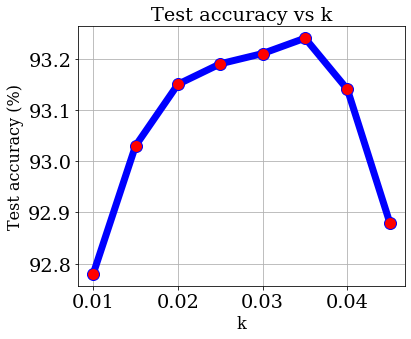

In [8]:
from matplotlib import rcParams


plt.tight_layout()

plt.rc('font', family='serif')
plt.rc('xtick', labelsize='large')
plt.rc('ytick', labelsize='large')
plt.rcParams.update({'font.size': 16})
rcParams.update({'figure.autolayout': True})


best_acc = [metrics[k]['best_val_acc'] for k in metrics.keys()]
k = list(metrics.keys())

plt.figure(figsize=(6,5))
plt.plot(k[1:-1],best_acc[1:-1],marker='o',color='blue',linewidth=7.0, markersize=12,mfc='red')
plt.title('Test accuracy vs k')
plt.xlabel('k')
plt.ylabel('Test accuracy (%)')
plt.grid(True)
# plt.show()
plt.savefig('figures/K_ablation/VGG16_cifar10_accuracy_VS_K.png')

In [10]:
k

dict_keys([0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05])